# Работа с уменьшенным датасетом Omniglot

---



# Загрузка уменьшенного датасета Omniglot

Загрузка датасета

In [99]:
from sklearn.metrics import accuracy_score
from google.colab import drive
import numpy as np
import os

drive.mount('/content/drive')

PATH = 'drive/My Drive/Few-Shot-Learning/Omniglot-data-set'

RANDOM_STATE = 17
NUMBER_OF_CLASSES = 100
AUGMENTATION_COUNT = 10

X_train_r = np.resize(np.loadtxt(os.path.join(PATH, 'train_images.txt'), dtype=np.uint8), (14 * NUMBER_OF_CLASSES, 1, 105, 105))
y_train_r = np.resize(np.loadtxt(os.path.join(PATH, 'train_labels.txt'), dtype='str'), (14 * NUMBER_OF_CLASSES))

X_test_r = np.resize(np.loadtxt(os.path.join(PATH, 'test_images.txt'), dtype=np.uint8), (6 * NUMBER_OF_CLASSES, 1, 105, 105))
y_test_r = np.resize(np.loadtxt(os.path.join(PATH, 'test_labels.txt'), dtype='str'), (6 * NUMBER_OF_CLASSES))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Определение аугментации

In [103]:
!pip install -q -U albumentations
import albumentations as A

from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([A.SmallestMaxSize(max_size=105),
                             A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                             A.RandomCrop(height=84, width=84),
                             A.Normalize(mean=(0.5), std=(0.5)),
                             ToTensorV2(),])

test_transform = A.Compose([A.SmallestMaxSize(max_size=105),
                            A.CenterCrop(height=84, width=84),
                            A.Normalize(mean=(0.5), std=(0.5)),
                            ToTensorV2(),])

Определение тензоров с применением аугментации

In [122]:
import torch

train_images = torch.stack([train_transform(image=x[0])["image"] for x in X_train_r for _ in range(AUGMENTATION_COUNT)]).float()
test_images = torch.stack([test_transform(image=x[0])["image"] for x in X_test_r]).float()

classes = [y_train_r[14 * i] for i in range(NUMBER_OF_CLASSES)]

train_labels = torch.from_numpy(np.array([[i] for i in range(NUMBER_OF_CLASSES) for _ in range(14 * AUGMENTATION_COUNT)])).long()
test_labels = torch.from_numpy(np.array([[i] for i in range(NUMBER_OF_CLASSES) for _ in range(6)])).long()

Определение вспомогательной функции для подготовки выборки

In [123]:
import random

def shuffle_tensor(tensor, batch_size):
    random.shuffle(tensor)

    images, labels = zip(*tensor)

    images = torch.stack(images[:])
    labels = torch.stack(labels[:])

    images = images.view(14 * NUMBER_OF_CLASSES * AUGMENTATION_COUNT // batch_size, batch_size, 1, 84, 84).float()
    labels = labels.view(14 * NUMBER_OF_CLASSES * AUGMENTATION_COUNT // batch_size, batch_size).long()

    return list(zip(images, labels))

# Визуализация датасета Omniglot (уменьшенный датасет)

label: Armenian_05


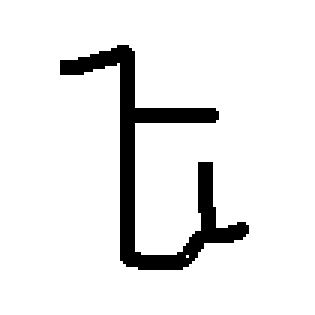

In [124]:
from PIL import Image

digit_number = -1

image = Image.fromarray(X_train_r[digit_number].reshape(105, 105), mode='P')

print('label: {}'.format(y_train_r[digit_number]))
display(image.resize((315, 315)))

# Использование полносвязной нейронной сети для решения задачи классификации рукописных символов (уменьшенный датасет, аугментация выборки)

Создание полносвязной нейронной сети

In [125]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(84 * 84, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)

    def forward(self, x):
        x = x.view(-1, 84 * 84)
        x = F.relu(self.drop(self.fc1(x)))
        x = F.relu(self.drop(self.fc2(x)))
        x = self.fc3(x)
        return x

Обучение полносвязной нейронной сети

In [ ]:
import torch.optim as optim

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for iteration in range(100):
    trainset = shuffle_tensor(list(zip(train_images, train_labels)), 50)

    for data in trainset:
        images, labels = data

        optimizer.zero_grad()

        labels_pred = net(images.unsqueeze(0))
        loss = criterion(labels_pred, labels)

        loss.backward()
        optimizer.step()

Использование полносвязной нейронной сети

In [171]:
labels_pred = net(test_images)
_, predicted = torch.max(labels_pred, 1)

Вычисление метрик

In [172]:
print('accuracy {:.3}'.format(accuracy_score(test_labels.detach().numpy().T[0], predicted.detach().numpy())))

accuracy 0.775


# Использование сверточной нейронной сети для решения задачи классификации рукописных символов (уменьшенный датасет, аугментация выборки)

Создание сверточной нейронной сети

In [180]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3)
    self.conv2 = nn.Conv2d(16, 32, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.bnorm1 = nn.BatchNorm2d(16)
    self.bnorm2 = nn.BatchNorm2d(32)
    self.drop = nn.Dropout(p=0.2)
    self.fc1 = nn.Linear(32 * 19 * 19, 1000)
    self.fc2 = nn.Linear(1000, 100)

  def forward(self, x):
    x = F.relu(self.bnorm1(self.pool(self.conv1(x))))
    x = F.relu(self.bnorm2(self.pool(self.conv2(x))))
    x = x.view(-1, 32 * 19 * 19)
    x = F.relu(self.drop(self.fc1(x)))
    x = self.fc2(x)
    return x


Обучение сверточной нейронной сети

In [ ]:
import torch.optim as optim

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for iteration in range(10):
    trainset = shuffle_tensor(list(zip(train_images, train_labels)), 50)

    for data in trainset:
        images, labels = data

        optimizer.zero_grad()

        labels_pred = net(images)
        loss = criterion(labels_pred, labels)

        loss.backward()
        optimizer.step()

Использование сверточной нейронной сети

In [184]:
labels_pred_s = net(test_images)
_, predicted_s = torch.max(labels_pred_s, 1)

Вычисление метрик

In [185]:
print('accuracy {:.3}'.format(accuracy_score(test_labels.detach().numpy().T[0], predicted_s.detach().numpy())))

accuracy 0.908


# Сравнение результатов работы нейронных сетей с классическими методами машинного обучения для датасета Omniglot (уменьшенный датасет, аугментация выборки)

In [186]:
from sklearn.metrics import accuracy_score

print('Neural network accuracy              : {:.3}'.format(accuracy_score(test_labels.detach().numpy().T[0], predicted.detach().numpy())))
print('Convolutional Neural network accuracy: {:.3}'.format(accuracy_score(test_labels.detach().numpy().T[0], predicted_s.detach().numpy())))

Neural network accuracy              : 0.775
Convolutional Neural network accuracy: 0.908


Аугментация выборки дала ощутимый прирост к итоговой метрике качества. По сравнению с использованием обычной выборки без искусственного ее увеличения данная техника позволила получить результаты в полтора раза лучше. Следует отметить, что хоть и параметры подбирались тщательным образом, при лучшей настройке можно получить более высокие результаты. Пространством для маневра тут является как и ахритектура нейронных сетей и ее обучение, так и подбор параметров аугментации.